# 혼공머 08-2
> 합성곱 신경망을 사용한 이미지 분류

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김동준
- categories : ["Python", "혼공머"]

# 주로쓰는 패키지들

In [125]:
#collapse
import numpy as np #넘파이
import pandas as pd #판다스
from plotnine import *  #플롯나인
import matplotlib.pyplot as plt #맷플랏립
import plotly.express as px #플랏리 상호작용 그래프
from IPython.display import HTML #블로그에 html로 올리려고 변환하는 패키지
import seaborn as sns # 씨본, 히스토그램 깔끔하게 그리는 패키지
#___________________________________

from sklearn.neighbors import KNeighborsClassifier # k 최근접이웃
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor  # 결정계수 
from sklearn.metrics import mean_absolute_error # 타깃과 예측의 절댓값 오차 평균을 반환
from sklearn.linear_model import LinearRegression # 선형 회귀
from sklearn.preprocessing import PolynomialFeatures #다중회귀로의 변환기
from sklearn.preprocessing import StandardScaler #규제
from sklearn.linear_model import Ridge #릿지
from sklearn.linear_model import Lasso #라쏘
from sklearn.linear_model import LogisticRegression # 로지스틱회귀
from scipy.special import expit #시그모이드함수
from scipy.special import softmax #소프트맥스함수
from sklearn.linear_model import SGDClassifier # 확률적 경사 하강법
from sklearn.tree import DecisionTreeClassifier # 트리
from sklearn.tree import plot_tree # 트리 모형
from sklearn.model_selection import cross_validate # 교차 검증
from sklearn.model_selection import StratifiedKFold # Kfold 교차 검증
from sklearn.model_selection import GridSearchCV # 그리드 서치 (하이퍼 파라미터 튜닝)
from scipy.stats import uniform, randint #랜덤 서치
from sklearn.model_selection import RandomizedSearchCV # 랜덤 서치 클래스
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 앙상블
from sklearn.ensemble import ExtraTreesClassifier # 엑스트라 트리 앙상블
from sklearn.ensemble import GradientBoostingClassifier # 그레이디언트 부스팅 앙상블

# 히스토그램 기반 그레이디언트 부스팅
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance # 특성중요도
from xgboost import XGBClassifier # 알고리즘을 구현한 또다른 라이브러리1
from lightgbm import LGBMClassifier # 알고리즘을 구현한 또다른 라이브러리2 , 마이크로소프트에서 구현 


# ____________________
from sklearn.cluster import KMeans # KMeans
from sklearn.decomposition import PCA # 주성분 분석

# 7장 딥러닝
from tensorflow import keras # 케라스 
import tensorflow as tf # 텐서플로

# 패션 MNIST 데이터 불러오기

> 합성곱 신경망은 2차원 이미지를 그대로 사용하기 위해 펼치는 과정이 없음

In [126]:
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

# 합성곱 신경망 만들기

In [127]:
# Sequential 객체를 만들고 첫번째 합성곱 층인 Conv2D를 추가(add() 메서드 사용)
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                              padding='same', input_shape=(28,28,1)))

> 이 합성곱층은 32개의 필터를 사용

> 커널의 크기는 (3,3) 이고 렐루 활성화 함수와 세임 패딩을 사용

> 완전 연결 신경망에서처럼 케라스 신경망 모델의 첫 번째 층에서 입력의 차원을 지정해야함

In [128]:
# 풀링층 추가

model.add(keras.layers.MaxPooling2D(2))

> 패션 MNIST 이미지가 (28,28) 크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일

> 특성맵의 크기는 절반으로 줄어듦

In [129]:
# 첫 번째 합성곱 - 풀링 층 다음에 두 번째 합성곱 -풀링 층을 추가
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

> 이 합성곱층은 세임 패딩을 사용. (입력의 가로 세로 크기를 줄이기 않음)

In [130]:
# 3차원 특성 맵을 일렬로 펼치기 ( 마지막에 10개의 뉴런을 가진 출력층에서 확률을 계산하기 때문)
# 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 하나 더 둠
# 즉 Flatten 클래스 다음에 Dense 은닉층, 마지막으로 Dense 출력층의 순서대로 구성

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

> 은닉층과 출력층 사이에 드롭아웃을 넣음.

> 드롭아웃 층이 은닉층의 과대적합을 막아 성능을 조금 더 개선

> 은닉층은 100개의 뉴런을 사용하고 활성화 함수는 합성곱 층과 마찬가지로 렐루 함수 사용

> 패션 MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 층의 활성화 함수는 소프트 맥스를 사용

In [131]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 3136)              0         
                                                                 
 dense_10 (Dense)            (None, 100)              

> 합성곱 층과 풀링 층의 효과가 잘 나타나 있음.

> 첫 번쨰 합성곱 층을 통과하면서 특성 맵의 깊이는 32가 되고 두 번째 합성곱에서 특성 맵의 크기가 64로 늘어남

> 특성 맵의 가로세로 크기는 첫 번째 풀링 층에서 절반으로 줄어들고 두 번째 풀링층에서 다시 절반으로 더 줄어듦 ( 최종 특성 맵의 크기는 (7,7,64) )

### 모델 파라미터의 개수 계산

> 첫 번째 합성곱 층은 32개의 필터를 가지고 있고 크기가 (3,3), 깊이가 1이고, 필터마다 하나의 절편이 있다.

>> 총 3x3x1x32+32 = 320 개의 파라미터가 있다.

In [135]:
# 층의 구성을 그림으로 표현

keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=300)

# 모델 컴파일과 훈련

> 케라스 API의 장점은 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 점이다.

In [136]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 19s 12ms/step - loss: 0.5174 - accuracy: 0.8125 - val_loss: 0.3248 - val_accuracy: 0.8813
Epoch 2/20
1500/1500 [==============================] - 17s 12ms/step - loss: 0.3431 - accuracy: 0.8770 - val_loss: 0.2858 - val_accuracy: 0.8939
Epoch 3/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2939 - accuracy: 0.8931 - val_loss: 0.2550 - val_accuracy: 0.9037
Epoch 4/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2619 - accuracy: 0.9043 - val_loss: 0.2327 - val_accuracy: 0.9162
Epoch 5/20
1500/1500 [==============================] - 19s 12ms/step - loss: 0.2409 - accuracy: 0.9120 - val_loss: 0.2313 - val_accuracy: 0.9120
Epoch 6/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2204 - accuracy: 0.9202 - val_loss: 0.2190 - val_accuracy: 0.9183
Epoch 7/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2007 - accuracy: 0.9268 - val_loss: 0.2221 -

> 훈련세트의  정확도가 이전보다 훨씬 좋아졌다.

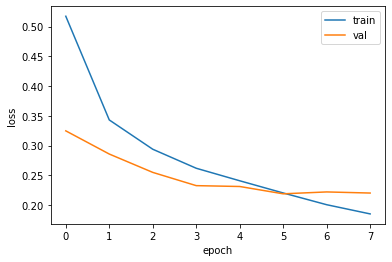

In [137]:
# 손실 그래프로 조기 종료가 잘 이루어졌는지 확인

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

> 검증 세트에 대한 손실이 점차 감소하다가 정체되기 시작하고 훈련 세트에 대한 손실은 점점 더 낮아지고 있다.

> 아홉 번째 에포크를 최적으로 생각할 수 있다.

In [138]:
# 세트에 대한 성능 평가

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2190 - accuracy: 0.9183


[0.2189749926328659, 0.9182500243186951]

> 이 결과는 fit 메서ㅏ드의 출력 중 아홉 번째 에포크의 출력과 같다.

> EalryStopping 콜백이 model 객체를 최상의 모델 파라미터로 잘 복원

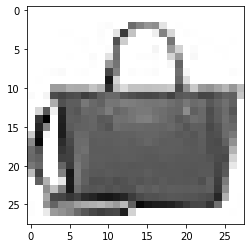

In [139]:
# predit() 메서드를 활용하여 훈련된 모델 사용

plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

> 핸드백 이미지

In [140]:
# 모델이 이 이미지에 대해 어떤 예측을 만드는지 확인

preds = model.predict(val_scaled[0:1])
print(preds)

[[1.1478546e-13 1.5173621e-22 1.5546854e-14 1.3573404e-14 1.0424652e-14
  3.8627394e-13 1.3114199e-15 2.4451533e-15 1.0000000e+00 3.5255428e-19]]


> 출력 결과를 보면 아홉 번째 값이 1이고 다른값이 거의 0에 가까움 

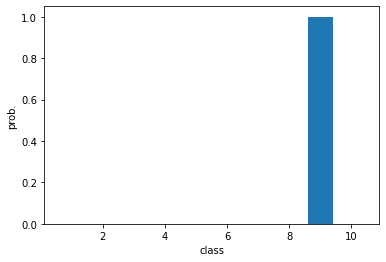

In [141]:
# 막대 그래프로 확인

plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [142]:
# 아홉 번째 클래스가 실제로 무엇이지 확인

classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [143]:
# 클래스 리스트가 있으면 레이블을 출력하기 쉽다.

print(classes[np.argmax(preds)])

가방


In [144]:
# 훈련 세트와 검증 세트에서 했던 것처럼 픽셀값의 범위를 0~1 사이로 바꾸고 이미지 크기를 (28,28)에서 (28,28,1)로 변경

test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [145]:
# evalute() 메서드로 성능 평가

model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2392 - accuracy: 0.9131


[0.23924489319324493, 0.913100004196167]